# Delayed effect model

## Introduction

Consider the problem where at timestep 0 it is not known whether an individual becomes infected with a disease. The symptoms of the disease only become apparent sometime after then. The distribution of the lag before the symptoms are visible is known. What is the probability that the individual is infected given that the presence or absence of symptoms is known up until a given timestep?

In [2]:
# Import the required libraries
library(dplyr)
library(ggplot2)
library(gtable)
library(grid)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=8, repr.plot.height=4)

## Negative binomial model

The probability that a symptom occurs at each timestep is governed by a Negative Binomial model.

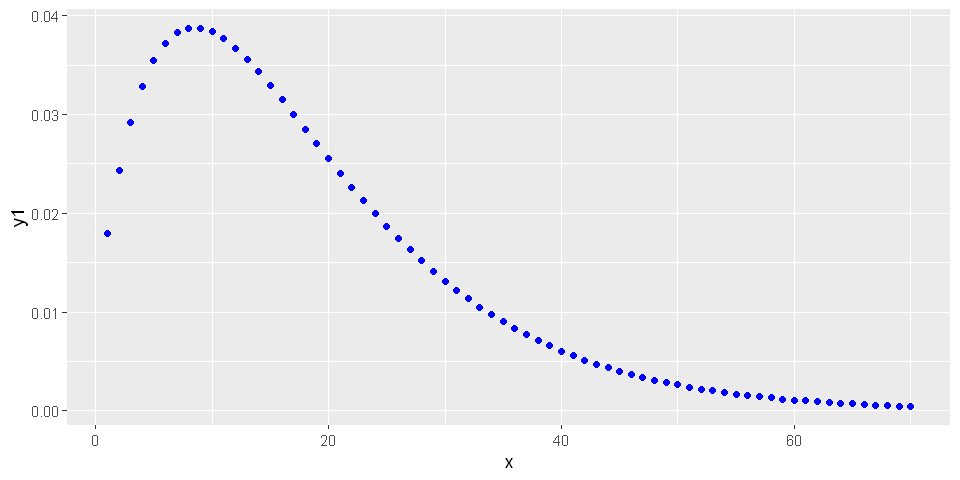

In [37]:
x = 1:70

# size = target number of successful trials, size > 0
# prob = probability of success in each trial, 0 <= prob <= 1
y1 = dnbinom(x, size=2, prob=0.1)

# Build a dataframe for plotting purposes
df = data.frame(x=x, y=y1)

ggplot(df, aes(x=x)) + 
    geom_point(aes(y=y1), color="blue")

In [4]:
# Generate a sample from the Negative Binomial model
rnbinom(1, size=3, prob=0.1)

[1] 24

## Data generation

Generate random data that may include an infection.

In [5]:
delayed_effect_model = function(p_infection, N, ns, ps) {
    # Generate samples
    #
    # Args:
    #   p_infection: Probability that the individual is infected at timestep 0.
    #   N: Number of timesteps.
    
    # Array to hold whether the individual is infected at each timestep
    symptoms = rep(0, N)
    
    # Is the individual infected?
    infected = rbinom(1, 1, p_infection)
    
    # If the individual is infected, generate the symptoms
    if (infected == 1) {
        
        # At what timestep do the symptoms first appear?
        appearance_timestep = rnbinom(1, ns, ps)
        
        # Fill the timesteps after the first symptom, provided the symptom occurs before
        # the last required timestep
        if (appearance_timestep <= N) {
            for (i in appearance_timestep:N) {
                symptoms[i] = 1
            }            
        }
    } else {
        appearance_timestep = NaN
    }
    
    # Postconditions
    stopifnot(infected == 0 || infected == 1)
    stopifnot(length(symptoms) == N)
    
    # Return the symptoms and whether the individual was actually infected
    list(infected=infected, 
         appearance_timestep=appearance_timestep,
         timesteps=1:N,
         symptoms=symptoms)
}

In [51]:
# Probability that the individual is infected at timestep 0
p_infection = 0.6

# Number of timesteps
N = 40

# Parameters of the delay model
ns = 2
ps = 0.1

# Generate the data
data = delayed_effect_model(p_infection, N, ns, ps) 
data

$infected
[1] 1

$appearance_timestep
[1] 33

$timesteps
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

$symptoms
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
[39] 1 1

## Bayesian inference for a single result at a known timestep

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 3
   Total graph size: 16

Initializing model



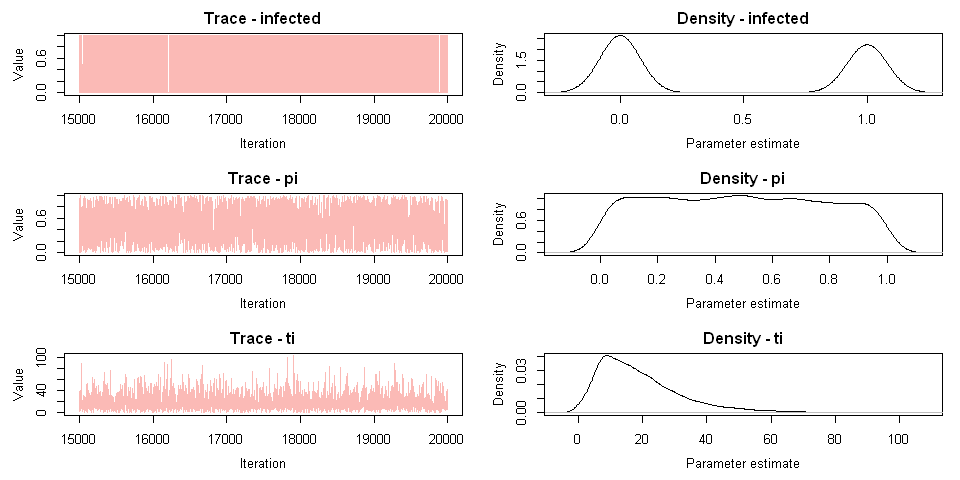

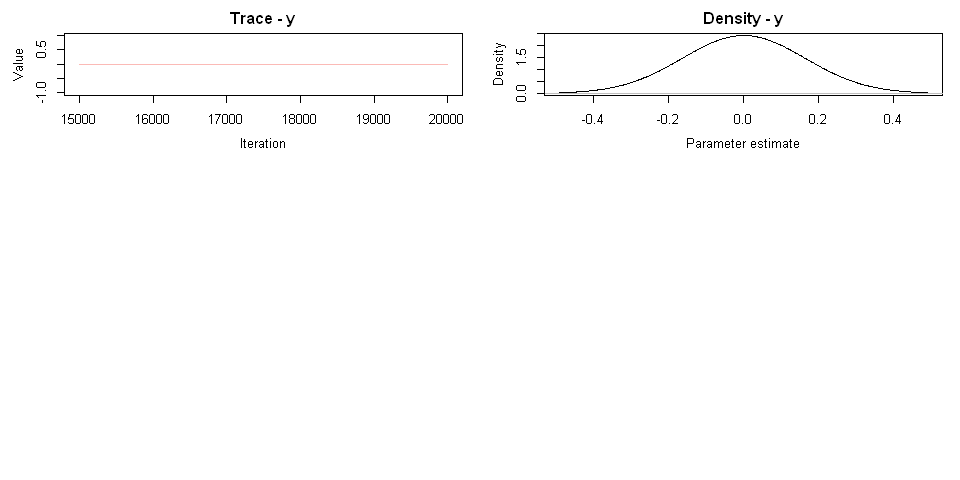

In [39]:
# Infer the parameters using JAGS for a single timestep
model_string = "
model {

    # Is the individual infected?
    pi ~ dbeta(1,1)         # Probability of an infection
    infected ~ dbern(pi)    # 0 => no, 1 => yes

    # Time at which the symptom appears if the individual is infected?
    ti ~ dnegbin(p, n)

    # Should the symptoms be visible at time step t? 1 => yes, 0 => no
    ta <- ifelse(ti <= t, 1, 0)

    # Symptom observed?
    # Can't make theta exactly zero with (1-infected)*0
    theta <- (1-infected)*1e-4 + infected*ta
    y ~ dbern(theta)
}
"

result = 0
t = 5

model = jags.model(textConnection(model_string),
                   data=list(y=result,
                             t=t, 
                             p=ps, 
                             n=ns))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("pi", "infected", "y", "ti"), 
                     n.iter=20000, progress.bar="none")

MCMCtrace(samp,
          pdf=FALSE)

## Bayesian inference for a time-series

In [40]:
data

$infected
[1] 1

$appearance_timestep
[1] 14

$timesteps
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

$symptoms
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 80
   Total graph size: 408

Initializing model



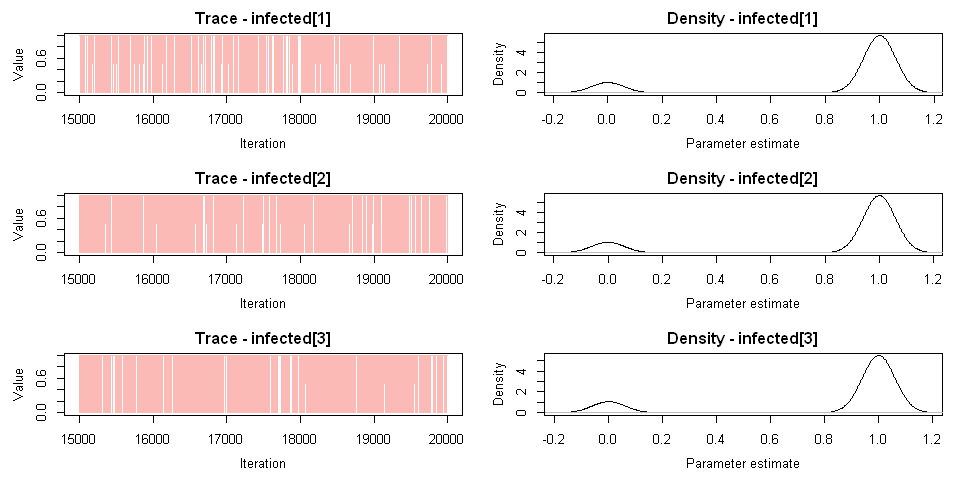

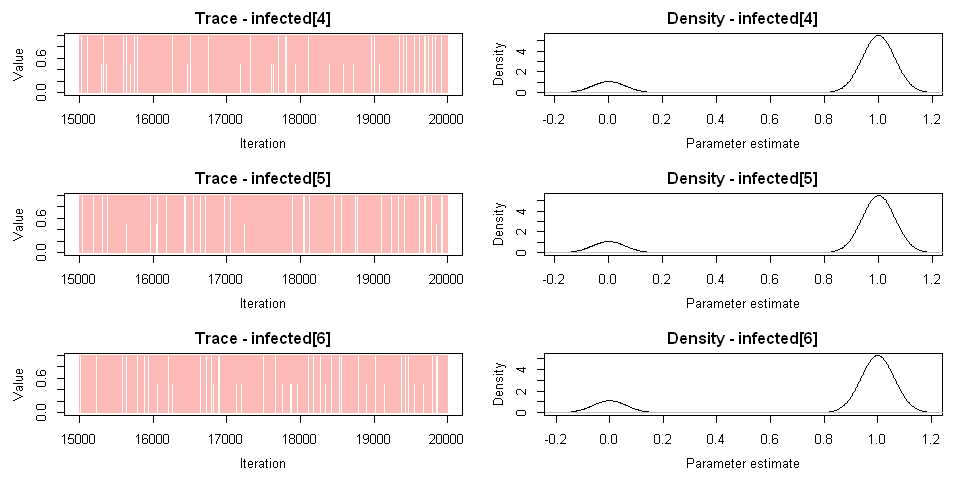

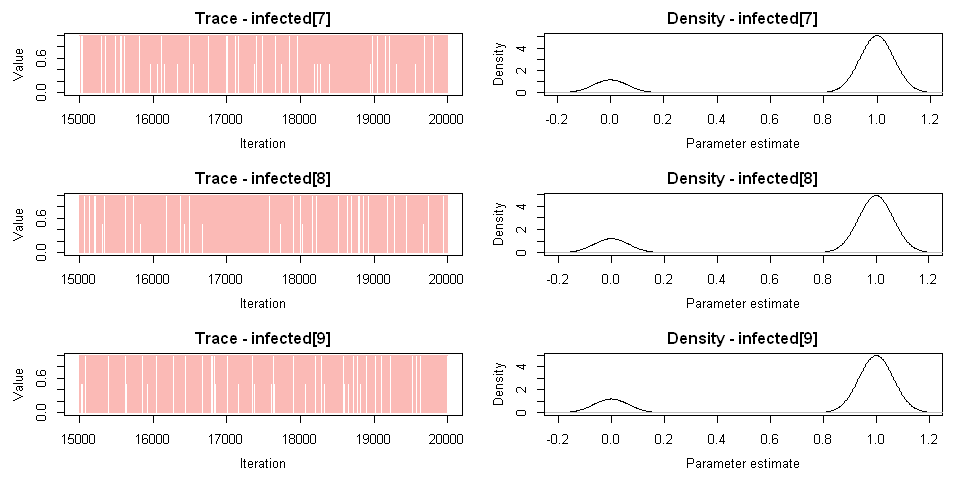

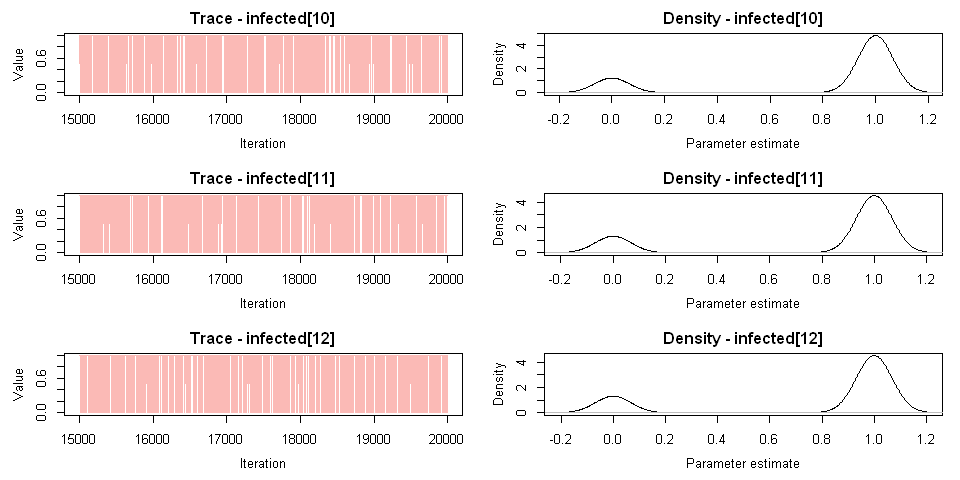

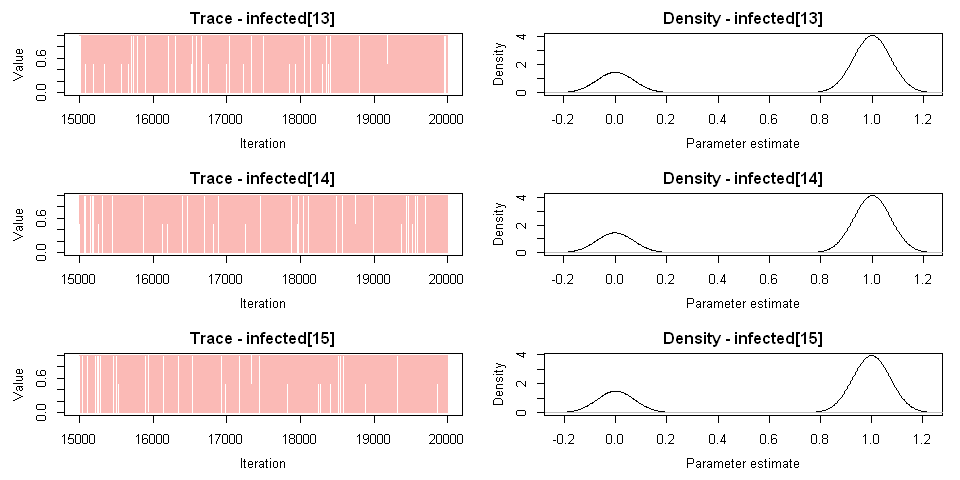

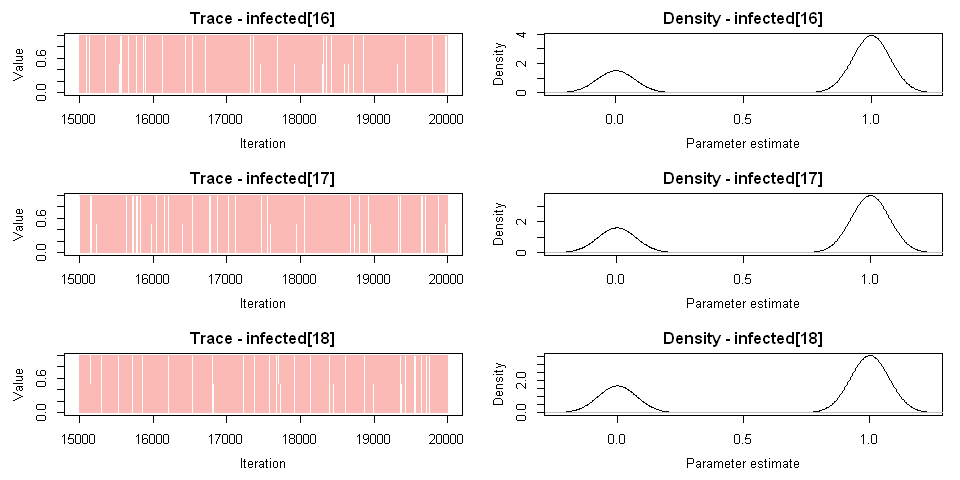

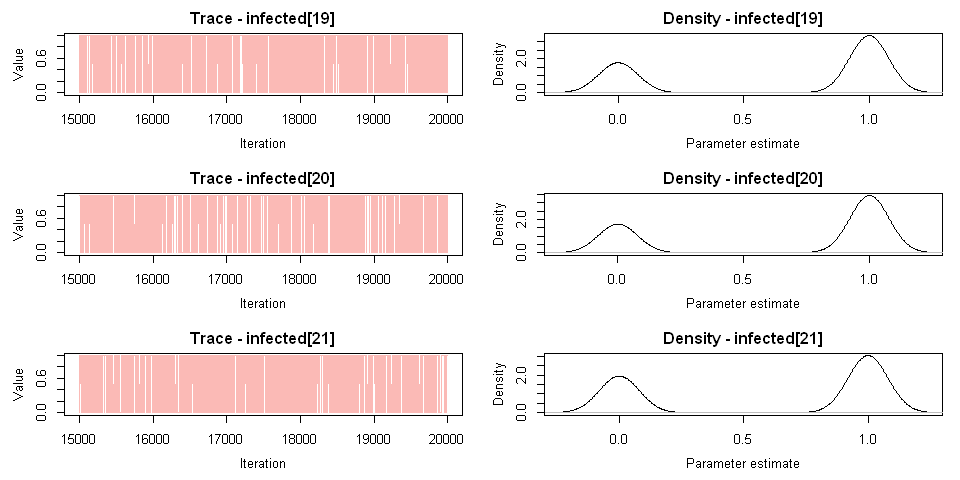

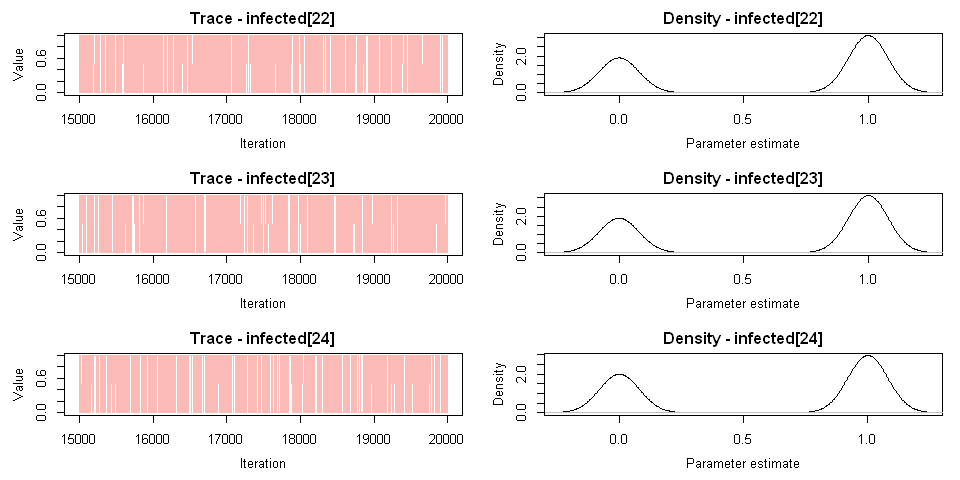

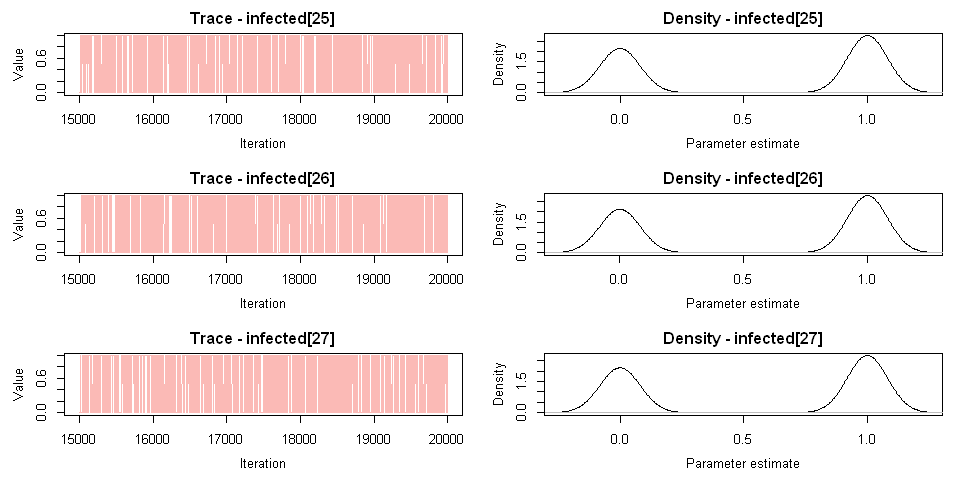

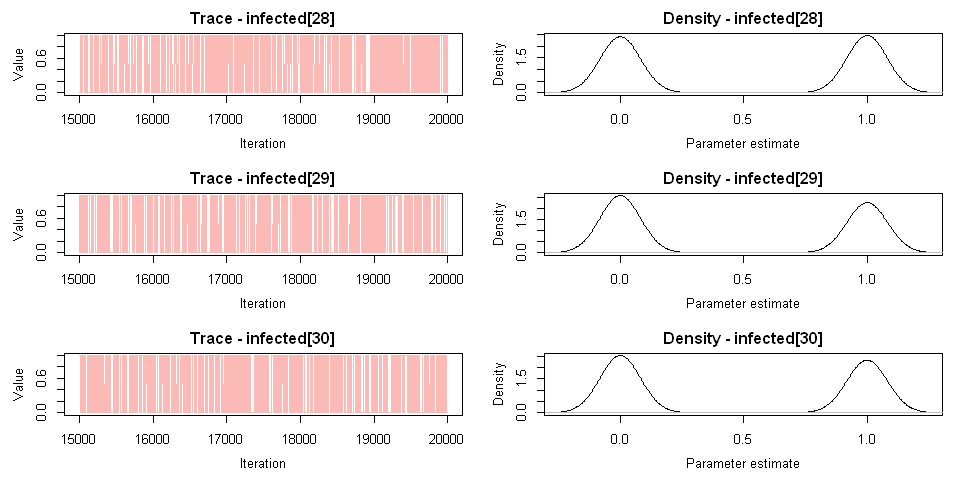

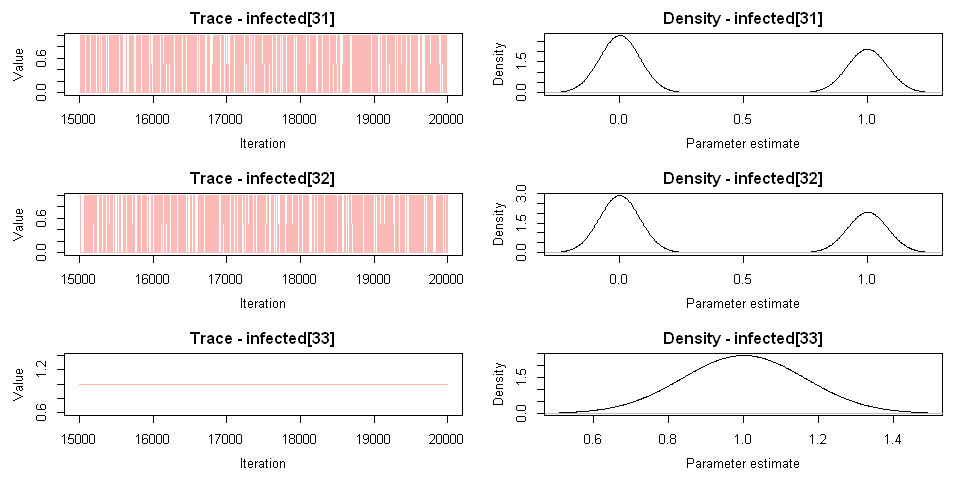

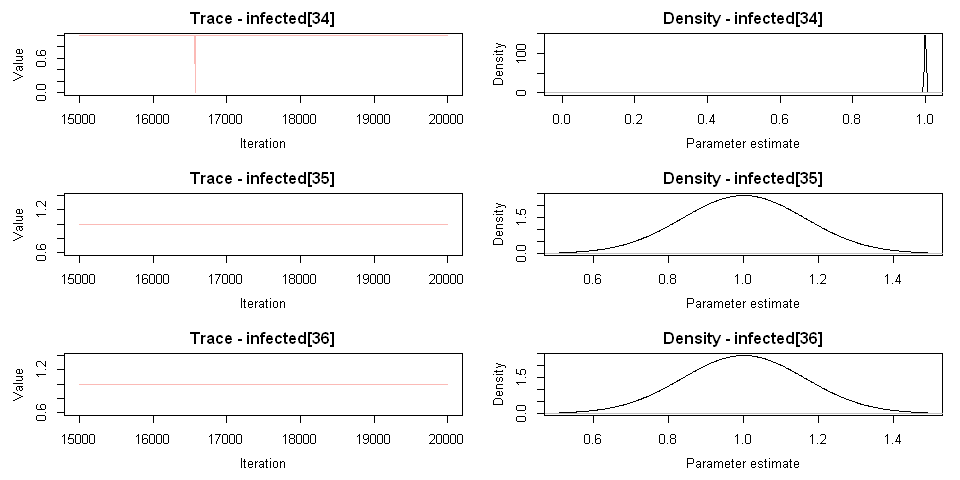

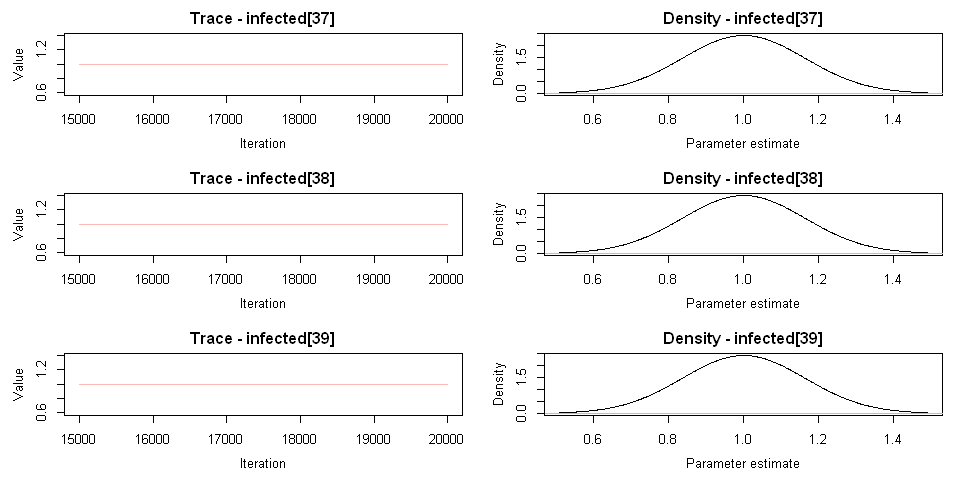

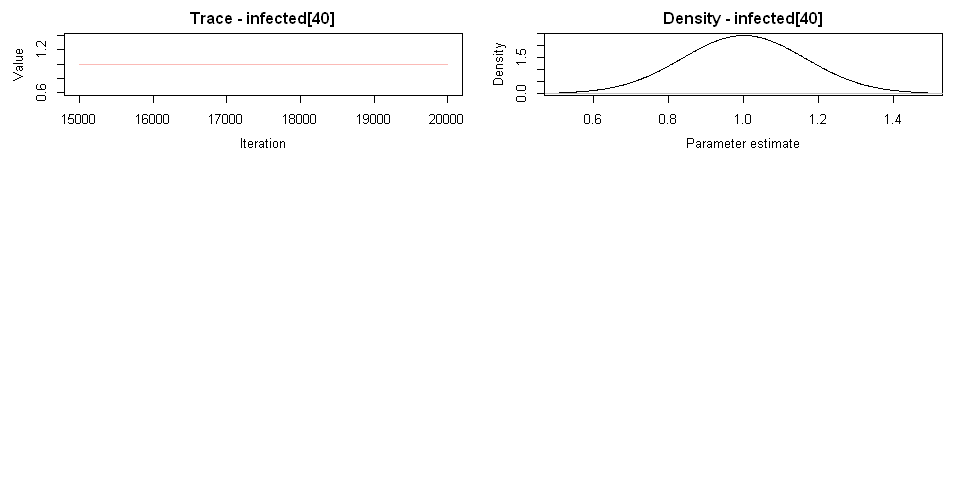

In [75]:
# Infer the parameters using JAGS for multiple timestep
model_string = "
model {

    # Walk through each timestep
    for (i in 1:Nt) {

        # Is the individual infected?
        infected[i] ~ dbern(p_infected)    # 0 => no, 1 => yes

        # Time at which the symptom appears if the individual is infected?
        ti[i] ~ dnegbin(p, n)

        # Should the symptoms be visible at time step t? 1 => yes, 0 => no
        ta[i] <- ifelse(ti[i] <= t[i], 1, 0)

        # Symptom observed at timestep?
        # theta can't exactly 0 or 1 as it causes an error
        theta[i] <- (1-infected[i])*1e-4 + infected[i]*ta[i]*0.9999
        y[i] ~ dbern(theta[i])
    }
}
"

# Preconditions
stopifnot(length(data$symptoms) == length(data$timesteps))

model = jags.model(textConnection(model_string),
                   data=list(y=data$symptoms,
                             Nt=length(data$timesteps),
                             t=data$timesteps,
                             p_infected=0.85,
                             p=ps, 
                             n=ns))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("infected"), 
                     n.iter=20000, progress.bar="none")

MCMCtrace(samp,
          pdf=FALSE)

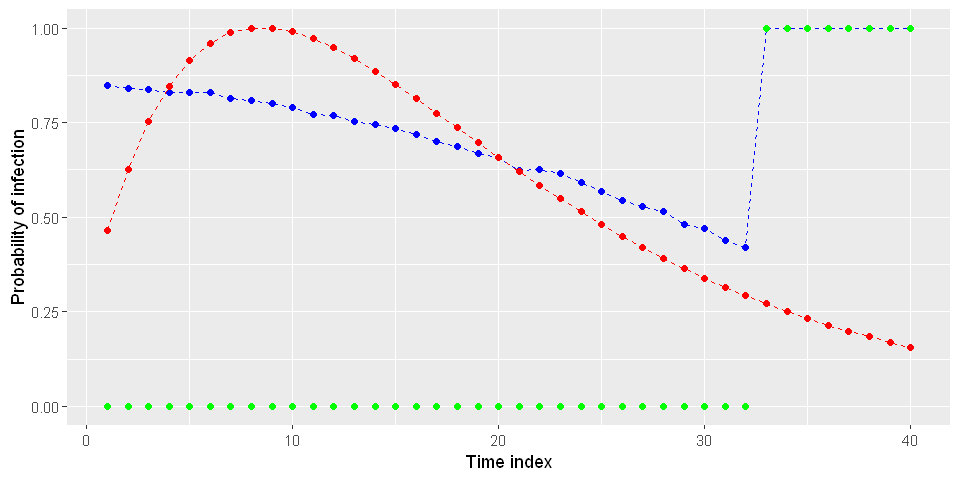

In [76]:
# Samples from JAGS chain
m = as.matrix(samp)

# Probability of infection at each timestep
p_infection = rep(NaN, length(data$timesteps))
for (i in 1:length(data$timesteps)) {
    
    # Samples of 1 (infected) or 0 (not infected)
    t = data$timesteps[i]
    var = paste0("infected[", t, "]")
    x = m[,var]

    p_infection[i] = sum(x == 1) / length(x)
}

# Negative binomial model
y1 = dnbinom(data$timestep, size=ns, prob=ps)
y1 = y1 / max(y1)

df = data.frame(time=data$timesteps, 
                p_infection=p_infection,
                nb=y1,
                symptom=data$symptoms)

ggplot(df, aes(x=time)) + 
    geom_point(aes(y=p_infection), color="blue") +
    geom_line(aes(y=p_infection), color="blue", linetype="dashed") +
    geom_point(aes(y=nb), color="red") +
    geom_line(aes(y=nb), color="red", linetype="dashed") +
    geom_point(aes(y=symptom), color="green") +
    ylim(0, 1) +
    xlab("Time index") +
    ylab("Probability of infection")